In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import pandas as pd
import numpy as np
from pacmagic_deeplearning.modeling.classifiers.bayesian.train_utils import make_performance_uncertainty_plot, cross_entropy

from utils import get_weight_tensor_from_class_weights, train, plot_calibration_curve, make_precision_accuracy_plot
from utils import NN

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score

In [2]:
X_train = pd.read_csv('../../data/MIMIC/X_train_processed.csv')
y_train = pd.read_csv('../../data/MIMIC/y_train.csv')

X_test = pd.read_csv('../../data/MIMIC/X_test_processed.csv')
y_test = pd.read_csv('../../data/MIMIC/y_test.csv')

In [3]:
data = torch.from_numpy(X_train.values).float()
target = torch.from_numpy(y_train.values).float()

data_val = torch.from_numpy(X_test.values).float()
target_val = torch.from_numpy(y_test.values).float()

In [5]:
optimal_weight = target.mean().item()

In [4]:
canonical = NN(quantiles=[optimal_weight])
optimizer = torch.optim.Adam(canonical.parameters(), lr=1e-2)
canonical = train(canonical, data, target, data_val,
                 target_val, optimizer, quantiles=[optimal_weight])

Validation loss: 0.09, Train loss: 0.12
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06


In [6]:
overconfident = NN(quantiles=[optimal_weight - 0.03])

overconfident.z = canonical.z
overconfident.z.weight.requires_grad = False
overconfident.z.bias.requires_grad = False

optimizer = torch.optim.Adam(overconfident.parameters(), lr=1e-2)

overconfident = train(overconfident, data, target, 
             data_val, target_val, optimizer, quantiles=[optimal_weight - 0.03])

Validation loss: 0.08, Train loss: 0.09
Validation loss: 0.06, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05
Validation loss: 0.05, Train loss: 0.05


In [7]:
underconfident = NN(quantiles=[optimal_weight + 0.03])

underconfident.z = canonical.z
underconfident.z.weight.requires_grad = False
underconfident.z.bias.requires_grad = False

optimizer = torch.optim.Adam(underconfident.parameters(), lr=1e-2)

underconfident = train(underconfident, data, target, 
             data_val, target_val, optimizer, [optimal_weight + 0.03])

Validation loss: 0.14, Train loss: 0.15
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.07, Train loss: 0.07


In [8]:
outputs_val = [underconfident(data_val)[0], canonical(data_val)[0], overconfident(data_val)[0]]

In [9]:
outputs = [torch.sigmoid(output) for output in outputs_val]

In [10]:
plots = []

for output in outputs:
    plots.append(plot_calibration_curve(y_test, output.detach().numpy()))

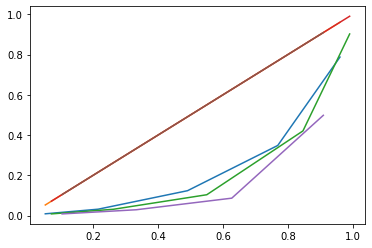

In [11]:
for plot in plots:
    plt.plot(plot[0], plot[1])
    plt.plot(plot[0], plot[0])
    
plt.show()

In [12]:
outputs_val = torch.stack([torch.sigmoid(output_val.squeeze()) for output_val in outputs_val], dim=1).detach().numpy().round(3)

In [13]:
# optimal cutoff point
cutoff = np.percentile(outputs_val[:, 1], 100 * (1-y_train.values.mean()))
cutoff

0.8140380324371098

In [14]:
preds = (outputs_val > cutoff)

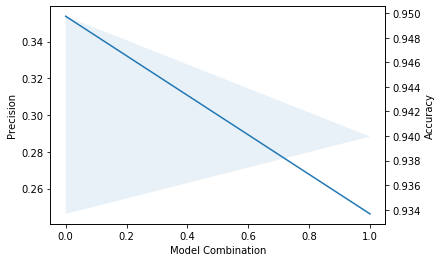

In [15]:
make_precision_accuracy_plot(outputs_val, preds, y_test)

Text(0, 0.5, 'Uncertainty')

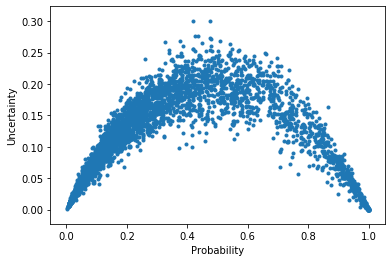

In [16]:
# uncertainties = np.std(outputs_val[:, 1:9], axis=-1)
# uncertainties = outputs_val[:, 1] - outputs_val[:, 9]
# uncertainties = outputs_val[:, 2] - outputs_val[:, 8]
# uncertainties = outputs_val[:, 3] - outputs_val[:, 7]
uncertainties = outputs_val[:, 2] - outputs_val[:, 0]

preds_50 = preds[:, 1]
# plt.scatter(outputs_val[:, 5][preds_50 == y_test.squeeze().values], uncertainties[preds_50 == y_test.squeeze().values], marker='.')
# plt.scatter(outputs_val[:, 5][preds_50 != y_test.squeeze().values], uncertainties[preds_50 != y_test.squeeze().values], marker='.')
plt.scatter(outputs_val[:, 1], uncertainties, marker='.')
plt.xlabel('Probability')
plt.ylabel('Uncertainty')


In [17]:
y_true = y_test.values.squeeze(-1)
y_prob = outputs_val[:, 1]
y_unc = uncertainties

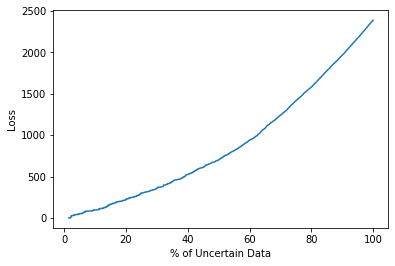

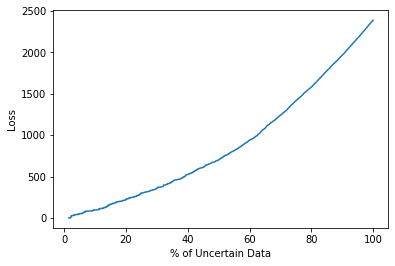

In [18]:
make_performance_uncertainty_plot(y_true, y_prob, y_unc, 'Loss', performance_fn_args={'reduction': 'sum'})

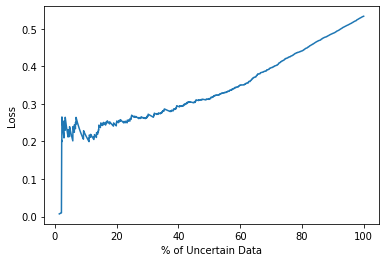

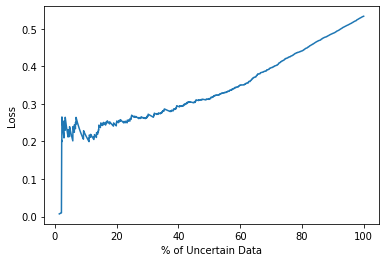

In [19]:
make_performance_uncertainty_plot(y_true, y_prob, y_unc, 'Loss', performance_fn_args={'reduction': 'mean'})

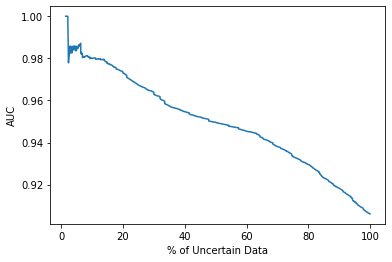

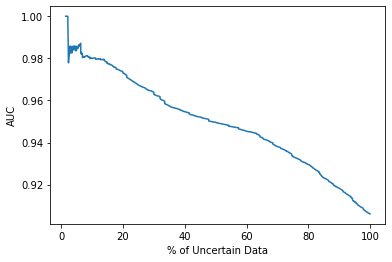

In [20]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'AUC', performance_fn=roc_auc_score)

In [21]:
from utils import loss_at_50

In [22]:
loss_at_50(y_true, y_prob, uncertainties)

703.4199216108536

In [23]:
cross_entropy(y_true, y_prob, reduction='sum')

2388.869338143966

In [24]:
false_predictions = preds_50 != y_test.squeeze()

In [25]:
roc_auc_score(false_predictions, uncertainties)

0.5551737470397757

In [26]:
average_precision_score(false_predictions, uncertainties)

0.07501356884584351

## Asymmetric entropy baseline

In [27]:
def asymmetric_entropy(p, w):
    return (p * (1 - p)) / ((-2 * w + 1) * p + w ** 2)


In [28]:
# uncertainties = asymmetric_entropy(outputs_val[:, 5], y_train.values.mean())
uncertainties = asymmetric_entropy(outputs_val[:, 1], cutoff)

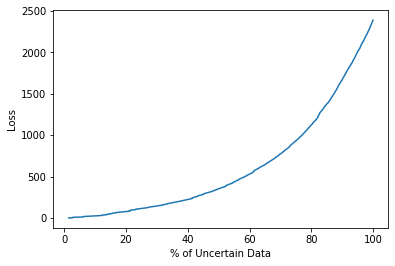

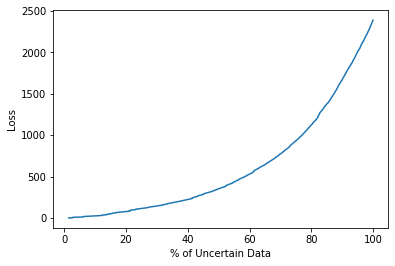

In [29]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'Loss', performance_fn_args={'reduction': 'sum'})

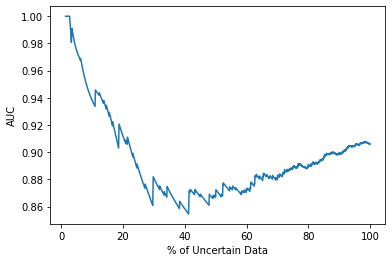

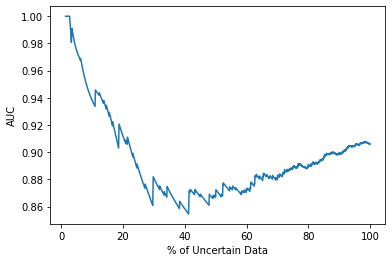

In [30]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'AUC', performance_fn=roc_auc_score)

In [31]:
loss_at_50(y_true, y_prob, uncertainties)

353.3069916948443

In [32]:
roc_auc_score(false_predictions, uncertainties)

0.8513318995376411

In [33]:
average_precision_score(false_predictions, uncertainties)

0.2971177197240937